In [41]:
import numpy as np
import pandas as pd
import myvariant
import vcf
from tqdm import tqdm
import Bio
from Bio.Data.IUPACData import protein_letters_3to1
import rhapsody as rd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

from utils import parser
from utils import file_info
from validation.cf_matrix import make_confusion_matrix
from validation.f1_distribution import posterior_distribution_f1_score

In [42]:
config = parser.load_config()

In [69]:
features_fname = '/home/anej/repos/studies/CBM/P2/cache/features_nsSNP_polyphen_train.csv'
features_labels_fname = '/home/anej/repos/studies/CBM/P2/cache/features_labels_nsSNP_polyphen_train_multiclass.csv'

## Features

## Classifier

In [70]:
X = pd.read_csv(features_fname).drop(columns='ID').to_numpy()
y = pd.read_csv(features_labels_fname).drop(columns='ID').to_numpy().flatten()

In [71]:
np.unique(y)

array([0, 1, 2, 3])

In [72]:
X.shape

(95369, 26)

In [73]:
scaler = StandardScaler()

feature_sel = SelectKBest(f_classif, k='all')
variance_sel = VarianceThreshold(threshold=0.00001)

# imputer = KNNImputer(n_neighbors=32)
imputer = SimpleImputer(strategy='mean')

In [74]:
X = imputer.fit_transform(X)

# X = variance_sel.fit_transform(X)

X = scaler.fit_transform(X)

X = feature_sel.fit_transform(X, y)

X = scaler.fit_transform(X)

In [75]:
T = X.copy()

In [76]:
X = T.copy()

In [ ]:
X = X[:, full_feature_importances > np.quantile(full_feature_importances, 1 - 0.5)]

In [ ]:
np.sum(full_feature_importances > np.quantile(full_feature_importances, 1 - 0.1))

In [ ]:
np.quantile(full_feature_importances, 0.9)

In [78]:
label_weights = compute_class_weight(
    'balanced', classes=np.unique(y), y=y)
weights = np.asarray([label_weights[j] for j in y])

In [79]:
n_splits = 5
k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)

feature_importances = np.zeros(shape=(X.shape[1],))

# cm = np.zeros(shape=(2, 2))
cm = np.zeros(shape=(4, 4))
val_auc_scores, fit_auc_scores = [], []
val_precision_scores, fit_precision_scores = [], []
val_recall_scores, fit_recall_scores = [], []
val_f1_scores, fit_f1_scores = [], []

for train_index, test_index in tqdm(k_fold.split(X, y), total=n_splits):

    X_fit = X[train_index]
    X_val = X[test_index]
    y_fit = y[train_index]
    y_val = y[test_index]
    fit_weights = weights[train_index]

    model = XGBClassifier(n_jobs=-1, objective='multi:softmax', num_class=4)
    # model = XGBClassifier(n_jobs=-1)
#     model = LogisticRegression(n_jobs=-1)
    model.fit(X_fit, y_fit, sample_weight=fit_weights)
    
    y_pred = model.predict(X_val)
    y_tr = model.predict(X_fit)

    val_f1_scores.append(f1_score(y_val, y_pred, average='micro'))
    fit_f1_scores.append(f1_score(y_fit, y_tr, average='micro'))

    # val_auc_scores.append(roc_auc_score(y_val, y_pred))
    # fit_auc_scores.append(roc_auc_score(y_fit, y_tr))

    # val_precision_scores.append(precision_score(y_val, y_pred))
    # fit_precision_scores.append(precision_score(y_fit, y_tr))

    # val_recall_scores.append(recall_score(y_val, y_pred))
    # fit_recall_scores.append(recall_score(y_fit, y_tr))

    cm += confusion_matrix(y_val, y_pred)

    feature_importances += (model.feature_importances_ / n_splits)

print(f'Train scores:\n\t' +
      f'F1 = {np.mean(fit_f1_scores)} +- {np.std(fit_f1_scores)}.')

print(f'Validation scores:\n\t' +
      f'F1 = {np.mean(val_f1_scores)} +- {np.std(val_f1_scores)}.')

# print(f'\nTrain scores:\n\t' +
#       f'F1 = {np.mean(fit_f1_scores)} +- {np.std(fit_f1_scores)}\n\t' +
#       f'AUC = {np.mean(fit_auc_scores)} +- {np.std(fit_auc_scores)}\n\t' +
#       f'precision = {np.mean(fit_precision_scores)} +- {np.std(fit_precision_scores)}\n\t' +
#       f'recall = {np.mean(fit_recall_scores)} +- {np.std(fit_recall_scores)}.')

# print(f'Validation scores:\n\t' +
#       f'F1 = {np.mean(val_f1_scores)} +- {np.std(val_f1_scores)}\n\t' +
#       f'AUC = {np.mean(val_auc_scores)} +- {np.std(val_auc_scores)}\n\t' +
#       f'precision = {np.mean(val_precision_scores)} +- {np.std(val_precision_scores)}\n\t' +
#       f'recall = {np.mean(val_recall_scores)} +- {np.std(val_recall_scores)}.')

100%|██████████| 5/5 [05:50<00:00, 70.18s/it]Train scores:
	F1 = 0.7342689969123741 +- 0.0024104614264822874.
Validation scores:
	F1 = 0.5748618466993707 +- 0.004420014917078315.



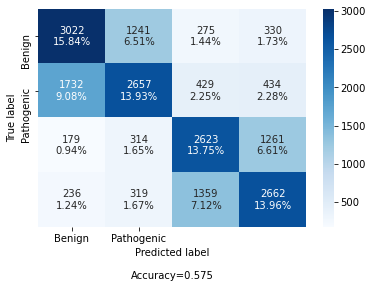

In [80]:
make_confusion_matrix(
    cm / n_splits, 
    group_names=[
        'True Negative',
        'False Positive',
        'False Negative',
        'True Positive'],
    categories=['Benign', 'Pathogenic'], 
    # categories=['Benign', 'Likely Benign', 'Likely Pathogenic', 'Pathogenic'], 
    cmap='Blues')

<AxesSubplot:>

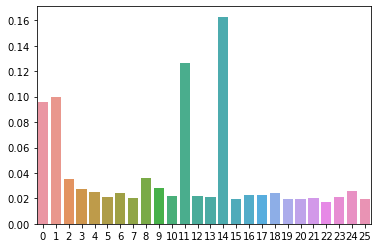

In [81]:
sns.barplot(np.arange(len(feature_importances)), feature_importances)

Mean: 0.6411854852428961, Stddev: 0.006137577785064416


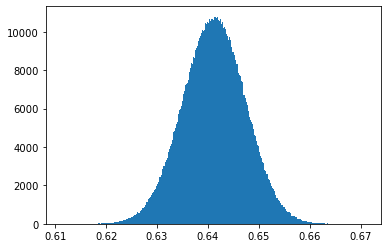

In [82]:
posterior_distribution_f1_score(cm / n_splits)

In [ ]:
full_feature_importances = np.copy(feature_importances)

## Final Model

In [ ]:
final_model = XGBClassifier(n_jobs=-1)
final_model.fit(X, y, sample_weight=weights)

In [ ]:
final_model.save_model(trained_model_fname)